__Прогнозирование расхода топлива автомобиля__

by Kornievskaya Anastasia Andreevna

__1. Описание набора данных и признаков __

В данном проекте рассматривается задача прогнозирования расхода топлива по городу для автомобилей по их параметрам. Данные по авто были нагло стырены с интернета. Данный прогноз можно использовать для предсказания расхода для вновь выпускаемых автомобилей в процессе их проектирования с целью оптимизации (если захочется такое прогнозировать)

__Список переменных:__

* Make - производитель автомобиля
* Model - модель автомобиля
* Type - тип кузова
* Origin - страна производитель
* DriveTrain - привод автомобиля
* MSRP - екомендованная производителем розничная цена
* Invoice - стоимость автомобиля в салонах
* EngineSize - бъем двигателя
* Cylinders - число цилидров для цилиндрового двигателя (для ротерного стоит '.')
* Horsepower - лошадиные силы
* Weight - вес автомобиля
* Wheelbase - колесная база (длина между колесами)
* Length - длина кузова
* **MPG_City** - расход топлива в городе (целевая переменная)
* MPG_Highway - расход топлива на трассе


In [529]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, LassoCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, mean_absolute_error, explained_variance_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

__2. Первичный анализ данных__

In [557]:
cars = pd.read_csv('../../data/cars.csv', delimiter=';', index_col='Obs')
cars['Invoice']=cars['Invoice'].apply(lambda x: float(x[1:].replace(',','.'))) # уберем доллар из цены
cars['Cylinders']=cars['Cylinders'].apply(lambda x: int(x.replace('.','0'))) # для ротерных двигателей поставим 0
y=cars['MPG_City']
cars=cars.drop(['MPG_City', 'MPG_Highway'], axis=1) # будет не честно прогнозировать расход по городу через расход на трассе
cars.head()

,Make,Model,Type,Origin,DriveTrain,MSRP,Invoice,EngineSize,Cylinders,Horsepower,Weight,Wheelbase,Length
Obs,,,,,,,,,,,,,
1,Acura,MDX,SUV,Asia,All,"$36,945",33.337,3.5,6,265,4451,106,189
2,Acura,RSX Type S 2dr,Sedan,Asia,Front,"$23,820",21.761,2.0,4,200,2778,101,172
3,Acura,TSX 4dr,Sedan,Asia,Front,"$26,990",24.647,2.4,4,200,3230,105,183
4,Acura,TL 4dr,Sedan,Asia,Front,"$33,195",30.299,3.2,6,270,3575,108,186
5,Acura,3.5 RL 4dr,Sedan,Asia,Front,"$43,755",39.014,3.5,6,225,3880,115,197


Разобьем нашу выборку на тренировочный и тестовый набор для финальной проверки прогноза.

In [531]:
X_train, X_valid, y_train, y_valid = train_test_split(cars, y, 
                     test_size=0.3, random_state=17)

In [532]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 299 entries, 301 to 112
Data columns (total 13 columns):
Make          299 non-null object
Model         299 non-null object
Type          299 non-null object
Origin        299 non-null object
DriveTrain    299 non-null object
MSRP          299 non-null object
Invoice       299 non-null float64
EngineSize    299 non-null float64
Cylinders     299 non-null int64
Horsepower    299 non-null int64
Weight        299 non-null int64
Wheelbase     299 non-null int64
Length        299 non-null int64
dtypes: float64(2), int64(5), object(6)
memory usage: 32.7+ KB


__3. Первичный визуальный анализ данных__

В данных довольно много категориальных признаков, но сначала посмотрим на числовые

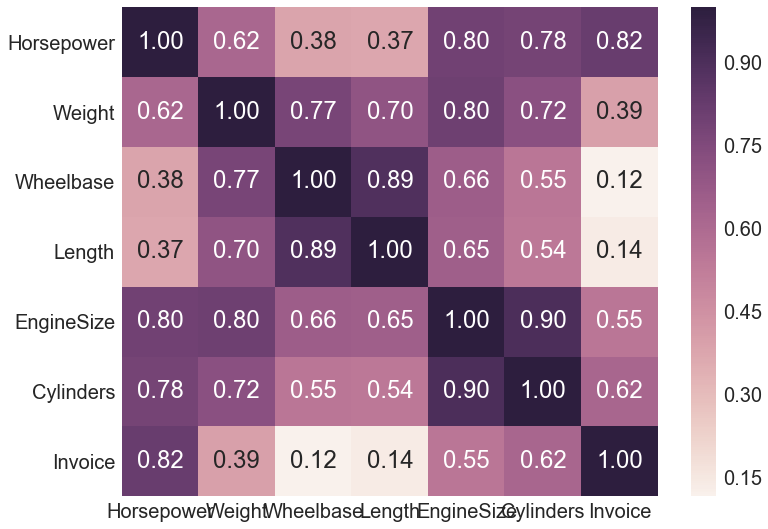

In [533]:
sns.set_context(
    "notebook", 
    font_scale = 2,       
    rc = { 
        "figure.figsize" : (12, 9), 
        "axes.titlesize" : 18
    }
)
sns.heatmap(X_train[['Horsepower',  'Weight' , 'Wheelbase' ,'Length','EngineSize', 'Cylinders' , 'Invoice']].corr()\
            , annot=True, fmt='.2f')


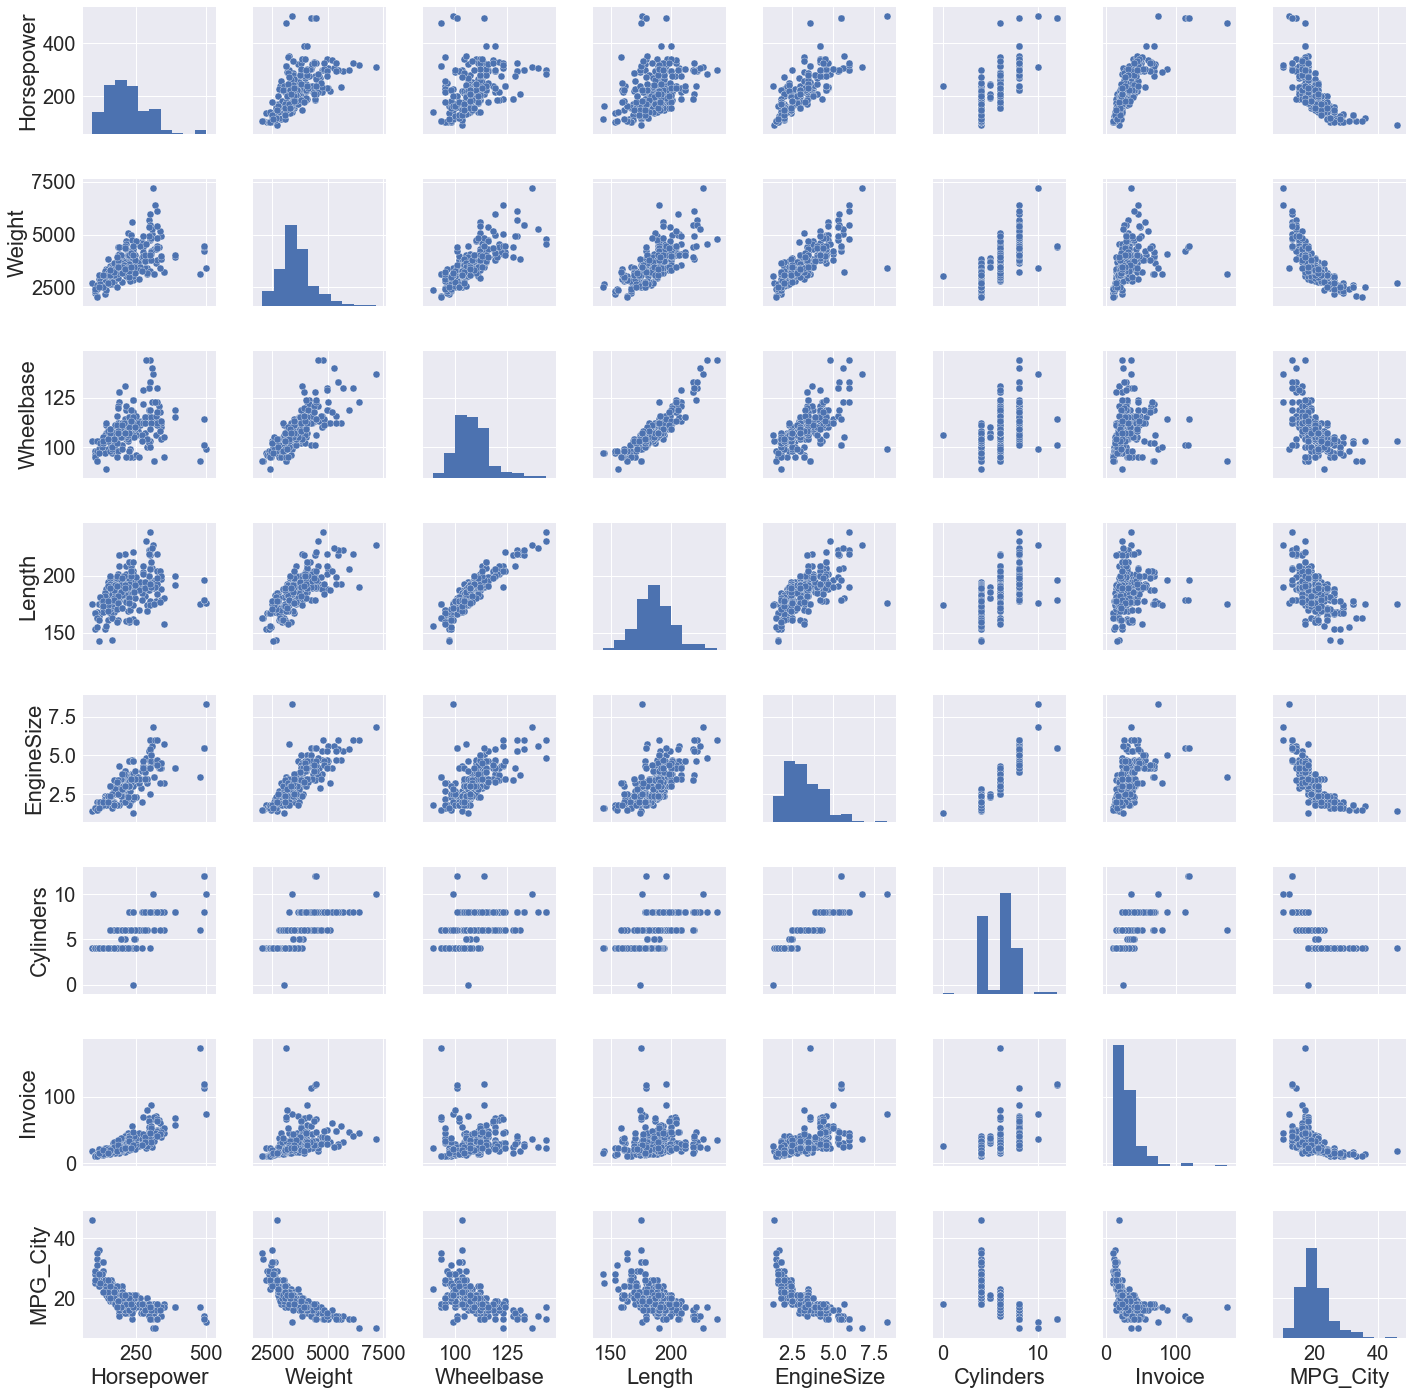

In [534]:

sns.pairplot(pd.concat([X_train[['Horsepower',  'Weight' , 'Wheelbase' ,'Length',\
                                 'EngineSize', 'Cylinders' , 'Invoice']], y_train], axis=1))


__4. Инсайты, найденные зависимости__

Из корреляции видно, что пары признаков

Length и Wheelbase  (длина и колесная база)

EngineSize и Cylinders (объем двигателя и число цилиндров)

сильно коррелированы (что довольно очевидно из предметной области) и по графикам видно, что зависимость линейна до невозможности, что будет плохо для нашей модели. Можем еще посмотреть на веса (ниже).
Также видно, что MPG_City зависит от признаков не линейно (на первый взглят квадратично) мы это потом используем для генерации новых признаков.

__5. Выбор метрики__ (совмещено с п.6)

__6. Выбор модели__

Я буду прогнозировать расход топлива как непрерывный отклик, т.е. с помощью линейной регрессии. Это обусловленно природой данных и возможностью интерпретировать соответствующие метрики.

Метрику возьмем довольно простую и понятную, а именно mean_absolute_error. Она нам покажет, но сколько в среднем мы "отдаляемся" от истиного значения.


__7. Предобработка данных__

Как ни крути, а для нормальной работы модели нужно стандартизовать данные. Используем StandardScaler

PCA использовать не будем. Для этого есть несколько причин. Во первых, мы уже убедились, что зависимость не оченьто и ленейна, а вовторых, потеряется интерпретируемость

In [535]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train[['Horsepower',  'Weight' , 'Wheelbase' ,'Length'\
                    ,'EngineSize', 'Cylinders' , 'Invoice']])

__8. Кросс-валидация и настройка гиперпараметров модели__

In [536]:
LR=LinearRegression()
LR.fit(X_train_scaled, y_train)
LR.coef_

array([-1.98694336, -2.5804148 ,  0.7639072 , -0.31478184, -0.50690058,
        0.08769192,  0.60041735])

Видно, что признак Cylinders имеет самый маленький вес - удалим

In [537]:
LR=LinearRegression()
LR.fit(X_train_scaled[:,[0,1,2,3,4,6]], y_train)
LR.coef_

array([-1.98897764, -2.58114337,  0.76582554, -0.31727851, -0.43389965,
        0.61669625])

видим, что Length тоже имеет довольно малый вес даже после удаления Cylinders + он сильно коррелирован с Wheelbase, так что тоже удалим

вообще надо посмотреть, что мы там по удаляли

In [538]:
score=cross_val_score(LinearRegression(), X_train_scaled, y_train, scoring='mean_absolute_error')
-np.mean(score)

1.6438279445044757

In [539]:
score=cross_val_score(LinearRegression(), X_train_scaled[:,[0,1,2,4,6]], y_train, scoring='mean_absolute_error')
-np.mean(score)

1.6444490430425562

ну.. мы удалили признаки и не сильно пострадал скор - это круто!

In [540]:
label_encoder = LabelEncoder()
label_encoder.fit(X_train['Type'])
X_train['Type2']=label_encoder.transform(X_train['Type'])
onehot_encoder = OneHotEncoder(sparse=False)
onehot_encoder.fit(X_train[['Type2']])
encoded_categorical_columns = pd.DataFrame(onehot_encoder.transform(X_train[['Type2']]))

In [541]:
t=pd.concat([pd.DataFrame(X_train_scaled[:,[0,1,2,4,6]], columns=['Horsepower',  'Weight' , 'Wheelbase' \
                    ,'EngineSize',  'Invoice']), encoded_categorical_columns], axis=1)

In [542]:
LR=LinearRegression()
LR.fit(t.drop(0, axis=1), y_train)
LR.coef_

array([ -1.47286638,  -2.47233611,   0.25597005,  -0.40661331,
         0.33927714, -20.79411057, -20.20126737, -21.66772453,
       -21.43371725, -20.25092358])

В общем не буду долго грузить этим отбором признаков - оставили тип Sedan и Sports

In [543]:
score=cross_val_score(LinearRegression(),  t.drop([0,1,4,5], axis=1), y_train, scoring='mean_absolute_error')
-np.mean(score)

1.6357450068916899

вуаля, немного улучшили.

In [544]:
X_train_scaled=t.drop([0,1,4,5], axis=1)
X_train_scaled=X_train_scaled.rename(columns={2: label_encoder.inverse_transform(2), 3: label_encoder.inverse_transform(3)})
X_train_scaled.head()

,Horsepower,Weight,Wheelbase,EngineSize,Invoice,Sedan,Sports
0,0.307520,0.381243,-0.268348,0.289820,-0.238621,0.0,0.0
1,0.698137,1.386676,0.543289,-0.251781,0.464990,0.0,0.0
2,-0.138899,0.423190,-0.152400,-0.612848,-0.023151,1.0,0.0
3,-0.138899,-0.005463,0.195444,-0.251781,0.284211,1.0,0.0
4,3.613813,-0.588798,-1.775674,0.380086,7.824466,0.0,1.0


__9. Создание новых признаков и описание этого процесса __

Помните, там выше было что-то про нелинейную зависимость из графиков. ВОТ ОНА.
Хотя на самом деле здесь имеет влияние не столько квадраты признаков,сколько сцепленный признак Horsepower*Weight

In [545]:
#X_train_scaled['Horsepower2']=X_train_scaled['Horsepower']*X_train_scaled['Horsepower']
#X_train_scaled['Weight2']=X_train_scaled['Weight']*X_train_scaled['Weight']
X_train_scaled['Horsepower_Weight']=X_train_scaled['Weight']*X_train_scaled['Horsepower']

In [546]:
score=cross_val_score(LinearRegression(),  X_train_scaled, y_train, scoring='mean_absolute_error')
-np.mean(score)

1.3310636414677288

не плохо, правда? наша модель довольно заметно улучшилась. Ну и это понятно из природы данных - чем тяжелее машина и более мощный в ней двигатель, тем больше она сожрет топлива, особенно в городе, где приходится много стоять

In [547]:
LR=LinearRegression()
LR.fit(X_train_scaled, y_train)
LR.coef_

array([-1.36876521, -2.97652454,  0.42806945, -0.71066787,  0.46217995,
        0.27041428, -0.7321422 ,  1.29176125])

заметим, что еще немного можно улучшить скор, убрав цену

In [548]:
score=cross_val_score(LinearRegression(),  X_train_scaled.drop('Invoice', axis=1), y_train, scoring='mean_absolute_error')
-np.mean(score)

1.3169218097693793

In [549]:
X_train_scaled=X_train_scaled.drop('Invoice', axis=1)
X_train_scaled.head()

,Horsepower,Weight,Wheelbase,EngineSize,Sedan,Sports,Horsepower_Weight
0,0.307520,0.381243,-0.268348,0.289820,0.0,0.0,0.117240
1,0.698137,1.386676,0.543289,-0.251781,0.0,0.0,0.968090
2,-0.138899,0.423190,-0.152400,-0.612848,1.0,0.0,-0.058781
3,-0.138899,-0.005463,0.195444,-0.251781,1.0,0.0,0.000759
4,3.613813,-0.588798,-1.775674,0.380086,0.0,1.0,-2.127805


__10. Построение кривых валидации и обучения __

In [550]:
from sklearn.learning_curve import learning_curve

In [551]:
def plot_with_std(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
        
def plot_learning_curve(clf, X, y, scoring, cv=5):
 
    train_sizes = np.linspace(0.05, 1, 20)
    n_train, val_train, val_test = learning_curve(clf,
                                                  X, y, train_sizes, cv=cv,
                                                  scoring=scoring, n_jobs = -1)
    plot_with_std(n_train, val_train, label='training scores', c='green')
    plot_with_std(n_train, val_test, label='validation scores', c='red')
    plt.xlabel('Training Set Size'); plt.ylabel(scoring)
    plt.legend()

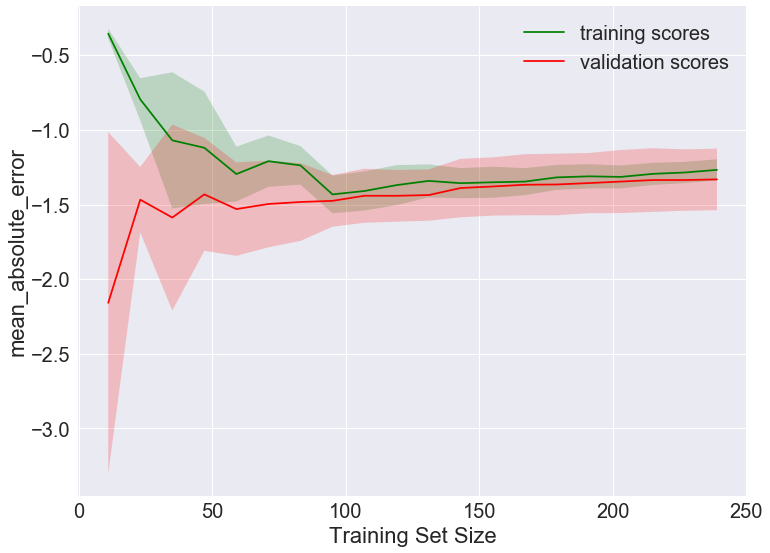

In [552]:
plot_learning_curve(LinearRegression(),X_train_scaled, y_train, scoring='mean_absolute_error')

И тут все довольно хорошо: Кривые сходятся, "зазор" маленький, причем тренд идет к нулю.

__11. Прогноз для тестовой или отложенной выборке __

In [553]:
X_valid_scaled=scaler.transform(X_valid[['Horsepower',  'Weight' , 'Wheelbase' ,'Length'\
                    ,'EngineSize', 'Cylinders' , 'Invoice']])
X_valid['Type2']=label_encoder.transform(X_valid['Type'])
encoded_categorical_columns2 = pd.DataFrame(onehot_encoder.transform(X_valid[['Type2']]))
t2=pd.concat([pd.DataFrame(X_valid_scaled[:,[0,1,2,4,6]], columns=['Horsepower',  'Weight' , 'Wheelbase' \
                    ,'EngineSize',  'Invoice']), encoded_categorical_columns2], axis=1)
X_valid_scaled=t2.drop([0,1,4,5], axis=1)
X_valid_scaled=X_valid_scaled.rename(columns={2: label_encoder.inverse_transform(2), 3: label_encoder.inverse_transform(3)})

X_valid_scaled['Horsepower_Weight']=X_valid_scaled['Weight']*X_valid_scaled['Horsepower']
X_valid_scaled=X_valid_scaled.drop('Invoice', axis=1)
X_valid_scaled.head()

,Horsepower,Weight,Wheelbase,EngineSize,Sedan,Sports,Horsepower_Weight
0,-0.180751,0.014200,0.427341,0.560620,1.0,0.0,-0.002567
1,-0.041245,-0.196849,-0.152400,0.019019,1.0,0.0,0.008119
2,0.893445,2.358028,0.543289,1.102221,0.0,0.0,2.106769
3,1.828136,-0.052654,-0.152400,0.019019,1.0,0.0,-0.096258
4,-0.362109,-0.688424,-1.543778,-0.793381,0.0,1.0,0.249284


In [554]:
LR=LinearRegression()
LR.fit(X_train_scaled, y_train)
mean_absolute_error(y_valid, LR.predict(X_valid_scaled))

1.7830793657133013

__12. Выводы __

В результате мы получили зависимость расхода топлива от параметров автомобиля, подвердили, что есть нелинейная зависимость от этих параметров. Можно было бы еще подобавлять параметры из категориальных признаков, но,  к сожалению, у меня они только ухудшали скор. Как уже говорилось выше, данный прогноз можно применять при проектировании авто, ведь если целевая группа - бюджетный потребитель, то расход топлива - один из основных показателей при выборе авто в такой группе клиентов.